In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from functools import partial

from datasplit import DataSplit
from preprocess import DataPreprocessor
from candidate_model import CandidateModel
from metrics import recall, recall_at_k, calc_mean_metric

## load & split

In [2]:
purchases = pd.read_csv('retail_train.csv')

# train/valid split
splitter = DataSplit(purchases, 'week_no', [6, 3])

train_lv1 = purchases[splitter.part0].copy()
valid_lv1 = purchases[splitter.part1].copy()

# prepare true values for validation
true_values = valid_lv1.groupby('user_id')['item_id'].unique().reset_index()
true_values.columns=['user_id', 'actual']

## prepare data

In [3]:
mix_feat_params = {
    'top_config': {'fields': ['quantity', 'sales_value'],
                   'beta': [1., 1.],
                   'k': 5000,
                   'scaler': StandardScaler
                    },
    'uim_config': {'aggfunc': 'sum', },
}

pre = DataPreprocessor(train_lv1, valid_lv1, **mix_feat_params)
pre.fit()

## research candidate models

In [4]:
candidate_params = {
    'train': pre.train_uim_sparse,
    'weighted': pre.train_uim_weighted,
    'top_items': pre.top_k_items,
    'placeholder_id': pre.placeholder_id,
    'idx_to_item': pre.idx_to_item,
    'item_to_idx': pre.item_to_idx,
    'user_to_idx': pre.user_to_idx
}

nearest_users_array = np.array([1, 2, 5])
models = ('ItemItem', 'Cosine', 'TFIDF', 'BM25', 'ALS')

### recall by n_candidates (same as recall@k, k = n_candidates)

при k - const, и
    n_candidates >= k:  recall@k - const, поскольку начало предиктов будет одинаковое
    n_candidates == k:  recall@k = recall
=> расчитываем recall

CPU times: user 33min 59s, sys: 17min 37s, total: 51min 36s
Wall time: 17min 44s


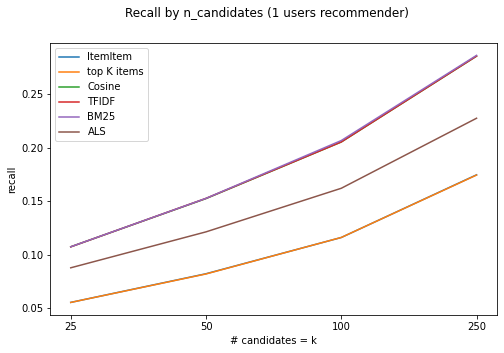

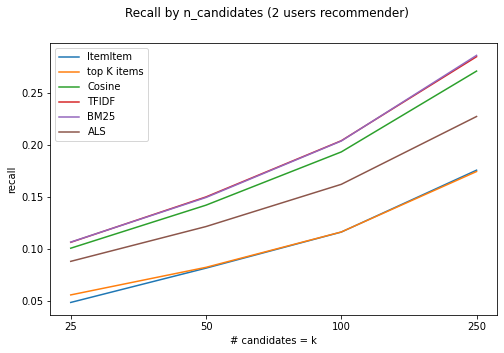

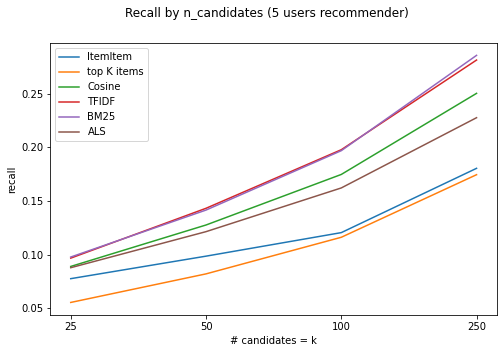

In [120]:
%%time
n_candidates_array = np.array([25, 50, 100, 250])

metrics = pd.DataFrame(columns=n_candidates_array.astype(str))
for nearest_users in nearest_users_array:
    for model_name in models:
        cm = CandidateModel(model_name, **candidate_params)
        if model_name == 'ALS':
            cm.fit()
        else:
            cm.fit(K=nearest_users)
        for n_cand in n_candidates_array:
            predicts = cm.predict(true_values['user_id'], N=n_cand)
            metrics.loc[model_name, str(n_cand)] = calc_mean_metric(recall, true_values['actual'], predicts)
            # top K metric
            recall_partial = partial(recall_at_k, pred_values=pre.top_k_items[:n_cand], k=n_cand)
            metrics.loc['top K items', str(n_cand)] = true_values['actual'].apply(recall_partial).mean()

    plt.figure(figsize=(8, 5))
    plt.suptitle(f'Recall by n_candidates ({nearest_users} users recommender)')
    plt.xlabel('# candidates = k')
    plt.ylabel(f'recall')
    plt.plot(metrics.T)
    plt.legend(labels=metrics.index)
    plt.savefig(f'recall_by_candidates({nearest_users}_users).png')

### recall@k by k (n_candidates - const)

CPU times: user 16min 10s, sys: 5min, total: 21min 10s
Wall time: 10min 55s


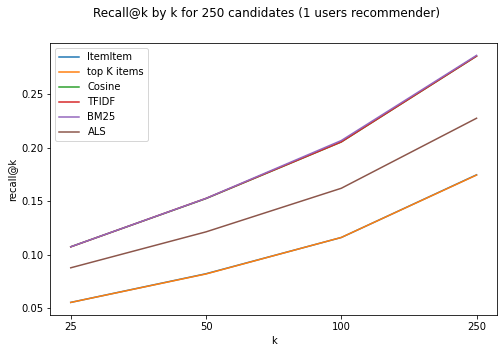

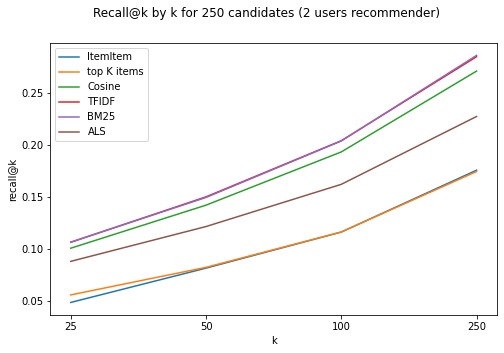

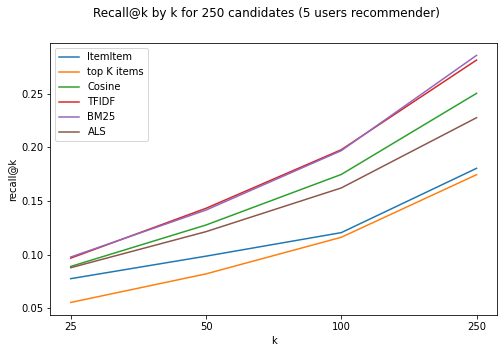

In [114]:
# %%time
# # это то же самое, что и предыдущее, но с возможностью задавать независимые значения K
#
# n_candidates = 250
# k_array = np.array([25, 50, 100, 250])
#
#
# metrics = pd.DataFrame(columns=k_array.astype(str))
# for nearest_users in nearest_users_array:
#     for model_name in models:
#         cm = CandidateModel(model_name, **candidate_params)
#         if model_name == 'ALS':
#             cm.fit()
#         else:
#             cm.fit(K=nearest_users)
#         predicts = cm.predict(true_values['user_id'], N=n_candidates)
#         for k in k_array:
#             metrics.loc[model_name, str(k)] = calc_mean_metric(recall_at_k, true_values['actual'], predicts, k=k)
#             # top K metric
#             recall_partial = partial(recall_at_k, pred_values=pre.top_k_items[:n_candidates], k=k)
#             metrics.loc['top K items', str(k)] = true_values['actual'].apply(recall_partial).mean()
#
#     plt.figure(figsize=(8, 5))
#     plt.suptitle(f'Recall@k by k for {n_candidates} candidates ({nearest_users} users recommender)')
#     plt.xlabel('k')
#     plt.ylabel(f'recall@k')
#     plt.plot(metrics.T)
#     plt.legend(labels=metrics.index)
#     # plt.savefig(f'recall_at_k_by_k_for_{n_candidates}_candidates({nearest_users}_users).png')

### recall@k by nearest users (n_candidates - const)

CPU times: user 43min 54s, sys: 6min 29s, total: 50min 24s
Wall time: 36min 17s


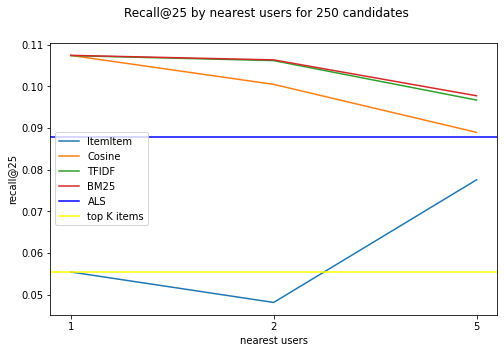

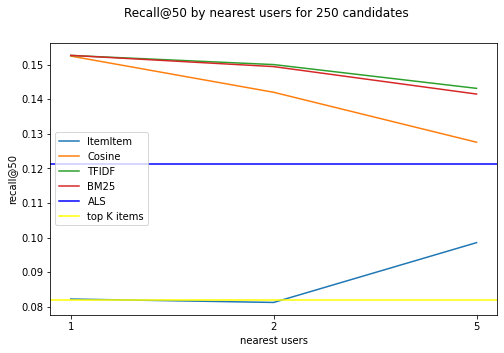

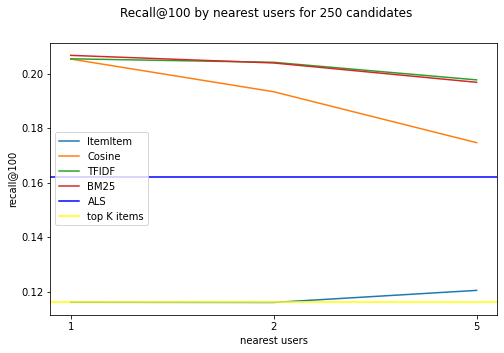

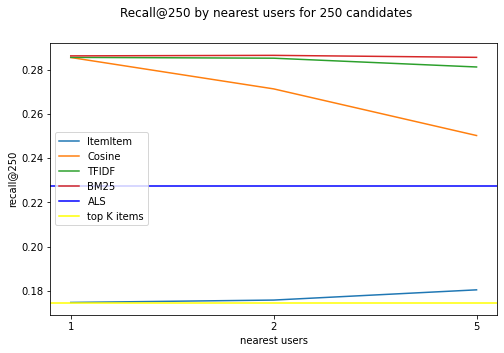

In [6]:
%%time
nearest_users_array = np.array([1, 2, 5])
n_candidates = 250
k_array = np.array([25, 50, 100, 250])
models = ('ItemItem', 'Cosine', 'TFIDF', 'BM25', 'ALS')

for k in k_array:
    metrics = pd.DataFrame(columns=nearest_users_array.astype(str))
    for nearest_users in nearest_users_array:
        for model_name in models:
            cm = CandidateModel(model_name, **candidate_params)
            if model_name == 'ALS':
                continue

            cm.fit(K=nearest_users)
            predicts = cm.predict(true_values['user_id'], N=n_candidates)
            metrics.loc[model_name, str(nearest_users)] = calc_mean_metric(recall_at_k, true_values['actual'], predicts, k=k)

    # ALS
    cm = CandidateModel('ALS', **candidate_params)
    cm.fit()
    als_predicts = cm.predict(true_values['user_id'], N=n_candidates)
    als_metric = calc_mean_metric(recall_at_k, true_values['actual'], als_predicts, k=k)
    # top K metric
    top_k_metric = true_values['actual'].apply(lambda tv: recall_at_k(tv, pre.top_k_items[:n_candidates], k=k)).mean()

    plt.figure(figsize=(8, 5))
    plt.suptitle(f'Recall@{k} by nearest users for {n_candidates} candidates')
    plt.xlabel('nearest users')
    plt.ylabel(f'recall@{k}')
    plt.plot(metrics.T)
    plt.axhline(als_metric, color='blue')
    plt.axhline(top_k_metric, color='yellow')
    plt.legend(labels=[*metrics.index, 'ALS', 'top K items'])
    plt.savefig(f'recall_at_{k}_by_nearest_users_for_{n_candidates}_candidates.png')

### BM25 own recommender

In [20]:
%%time
metrics = []
n_candidates = np.arange(40, 151, 5)
candidate_params = {
    'train': pre.train_uim_sparse,
    'weighted': pre.train_uim_weighted,
    'top_items': pre.top_k_items,
    'placeholder_id': pre.placeholder_id,
    'idx_to_item': pre.idx_to_item,
    'item_to_idx': pre.item_to_idx,
    'user_to_idx': pre.user_to_idx
}
cm = CandidateModel('BM25', **candidate_params)
cm.fit(K=1)     # BM25 own recommender
for n in n_candidates:
    predicts = cm.predict(true_values['user_id'], N=n)
    metrics.append(calc_mean_metric(recall, true_values['actual'], predicts,))

CPU times: user 4min 8s, sys: 64.8 ms, total: 4min 8s
Wall time: 4min 7s


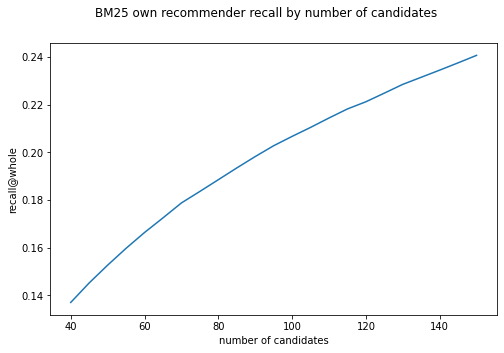

In [21]:
plt.figure(figsize=(8, 5))
plt.suptitle('BM25 own recommender recall by number of candidates')
plt.xlabel('number of candidates')
plt.ylabel('recall@whole')
plt.plot(n_candidates, metrics)
plt.savefig('recall_BM25(own_recommender)_by_n_candidates.png')

## conclusion

In [11]:
#